In [1]:
import tensorflow   #Low level Machine Learning Library
import os   #Operating
import sklearn  #High level ML library similar to Keras
import numpy    # Number Python - lets us do fancy list math
import keras #High level ML library that depends on tensorflow
import matplotlib.pyplot as plt    #Lets us graph stuff 
import pathlib      #Easier to wortk with paths
import collections
import shutil
import json

In [2]:
tensorflow.random.set_seed(41)
numpy.random.seed(41)

DATA_DIR = pathlib.Path("./Fish_Data/images/cropped")
all_images = list(DATA_DIR.glob("*.png"))

def get_species_for_filename(path):
    filename = path.stem
    parts = filename.rsplit('_', 1)
    return parts[0]

species_count = collections.Counter(get_species_for_filename(img) for img in all_images)
num_species = len(species_count)

In [3]:
ORGANIZED_DIR = pathlib.Path("./Fish_Data/organized/")

if not ORGANIZED_DIR.exists():
    ORGANIZED_DIR.mkdir(parents=True, exist_ok=True)

    for image in all_images:
        species = get_species_for_filename(image)

        species_folder = ORGANIZED_DIR / species
        species_folder.mkdir(exist_ok=True)

        dest_path = species_folder / image.name
        if not dest_path.exists():
            shutil.copy(image, dest_path)


train_dataset = keras.utils.image_dataset_from_directory(
    ORGANIZED_DIR,
    validation_split = 0.2,
    subset="training",
    seed=42,
    image_size = (224, 224),
    batch_size = 32,
    label_mode="categorical",
)

val_dataset = keras.utils.image_dataset_from_directory(
    ORGANIZED_DIR,
    validation_split = 0.2,
    subset="validation",
    seed=42,
    image_size = (224, 224),
    batch_size = 32,
    label_mode="categorical",
)

class_names = train_dataset.class_names
num_classes = len(class_names)
with open("class_names.json", "w") as jf:
    json.dump(class_names, jf, indent = 2)
    
print(class_names)
train_dataset = train_dataset.cache().prefetch(buffer_size=tensorflow.data.AUTOTUNE)
val_dataset_dataset = val_dataset.cache().prefetch(buffer_size=tensorflow.data.AUTOTUNE)



Found 4414 files belonging to 484 classes.
Using 3532 files for training.
Found 4414 files belonging to 484 classes.
Using 882 files for validation.
['A73EGS-P', 'CUNWCB-Y', 'Istiophorus_platypterus', 'P1ROZC-Z', 'PQV7DP-S', 'acanthaluteres_brownii', 'acanthaluteres_spilomelanurus', 'acanthaluteres_vittiger', 'acanthistius_cinctus', 'acanthopagrus_australis', 'acanthopagrus_berda', 'acanthopagrus_latus', 'achoerodus_gouldii', 'achoerodus_viridis', 'acreichthys_tomentosus', 'aesopia_cornuta', 'aethaloperca_rogaa', 'alectis_ciliaris', 'alectis_indica', 'alepes_kleinii', 'aluterus_monoceros', 'aluterus_scriptus', 'amanses_scopas', 'anampses_caeruleopunctatus', 'anampses_elegans', 'anampses_femininus', 'anampses_geographicus', 'anampses_lennardi', 'anampses_melanurus', 'anampses_meleagrides', 'anampses_neoguinaicus', 'anampses_twistii', 'anodontostoma_chacunda', 'anyperodon_leucogrammicus', 'aphareus_furca', 'aphareus_rutilans', 'aprion_virescens', 'argyrops_spinifer', 'aseraggodes_melanos

In [7]:
data_augmentation = keras.models.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
], name="augmentation")

base_model = keras.applications.EfficientNetB0(
    weights="imagenet",
    include_top = False,
    input_shape = (224, 224, 3)
)

base_model.trainable = False

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(224, 224,3)),

    data_augmentation,

    base_model,

    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(num_classes, activation='softmax')

], name="fish_classifier")

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\coron\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [8]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True

    ),
    keras.callbacks.ModelCheckpoint(
        'current_fish_model_calvin.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

In [35]:
train_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=callbacks
)

model.save("fish_model_calvin.keras")

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 247ms/step - accuracy: 0.0040 - loss: 6.1898 - val_accuracy: 0.0057 - val_loss: 6.1040
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - accuracy: 0.0136 - loss: 6.0275 - val_accuracy: 0.0125 - val_loss: 6.0104
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - accuracy: 0.0218 - loss: 5.8747 - val_accuracy: 0.0249 - val_loss: 5.8957
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 231ms/step - accuracy: 0.0314 - loss: 5.7059 - val_accuracy: 0.0465 - val_loss: 5.7681
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - accuracy: 0.0493 - loss: 5.5004 - val_accuracy: 0.0658 - val_loss: 5.6278
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 233ms/step - accuracy: 0.0764 - loss: 5.3057 - val_accuracy: 0.0862 - val_loss: 5.4835
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 235ms/step - accuracy: 0.1002 - loss: 5.1228 - val_accuracy: 0.0998 - val_loss: 5.3333
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 237ms/step - accuracy: 0.1121 - loss: 4

In [14]:
def predict_fish(image_path, model, show_n=5):
    image = keras.utils.load_img(image_path, target_size=(224, 224))
    image_array = keras.utils.img_to_array(image)
    image_array = numpy.expand_dims(image_array, axis=0)


    predictions = model.predict(image_array)
    top_indices = numpy.argsort(predictions[0])[-show_n:][::-1]
# Display results
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Show the image
    axes[0].imshow(image)
    axes[0].set_title("Input Image", fontsize=12)
    axes[0].axis('off')
    
    # Show predictions as bar chart
    species = [class_names[i][:20] for i in top_indices]  # Truncate long names
    probs = [predictions[0][i] * 100 for i in top_indices]
    colors = ['green' if i == 0 else 'steelblue' for i in range(len(species))]
    
    axes[1].barh(range(len(species)), probs, color=colors)
    axes[1].set_yticks(range(len(species)))
    axes[1].set_yticklabels(species)
    axes[1].set_xlabel('Confidence (%)')
    axes[1].set_title('Top Predictions', fontsize=12)
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    print(f"\nTop {show_n} Predictions")

    # for i, idx in enumerate(top_indices):
    #     print(f"    {i+1}.  {class_names[idx]}:  {predictions}")



    return class_names[top_indices[0]], predictions[0][top_indices[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


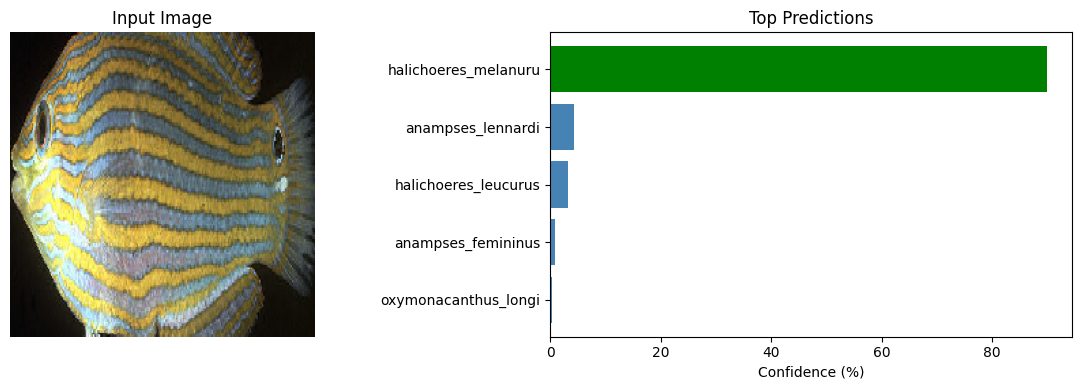


Top 5 Predictions
YActual Species: halichoeres_melanurus, Predicted Species: halichoeres_melanurus, Confidence: 0.90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


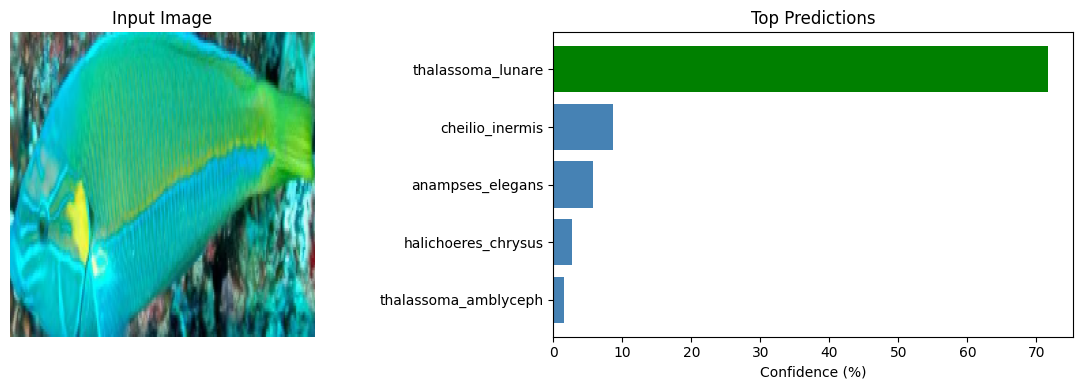


Top 5 Predictions
NActual Species: anampses_elegans, Predicted Species: thalassoma_lunare, Confidence: 0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


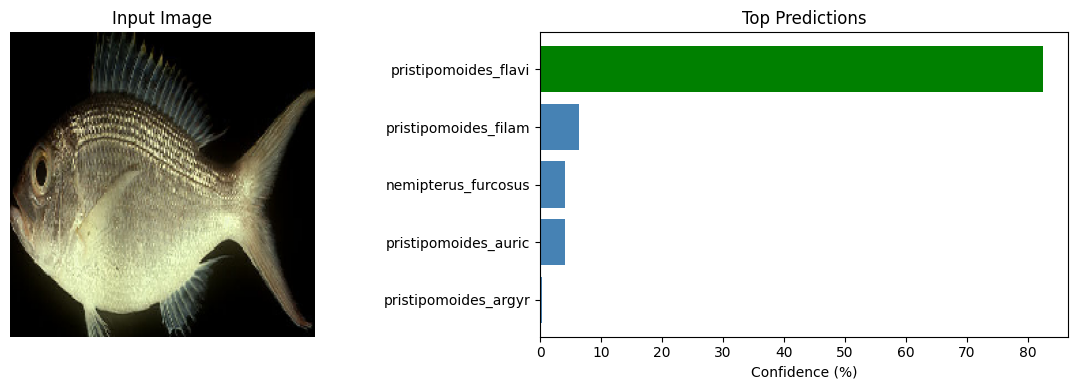


Top 5 Predictions
YActual Species: pristipomoides_flavipinnis, Predicted Species: pristipomoides_flavipinnis, Confidence: 0.83


In [ ]:
test_images = numpy.random.choice(all_images, size=3, replace=False)
model = keras.models.load_model("fish_model.keras")
for image in test_images:
    actual_species = get_species_for_filename(image)
    predicted, confidence = predict_fish(str(image), model)

    if predicted == actual_species:
        correct = "Y"
    else:
        correct = "N"
    print(f"{correct} Actual Species: {actual_species}, Predicted Species: {predicted}, Confidence: {confidence:.2f}")

In [5]:
import json
def get_class_names():
    """
    Get the list of fish species the model can identify.
    
    In a production app, this would typically be saved alongside the model.
    For now, we'll load it from the organized data directory structure.
    
    Returns:
        list: Sorted list of class names (fish species)
    """
    
    class_names_file = "class_names.json"
    class_names = []
    with open(class_names_file, "r") as jf:
        class_names = json.load(jf)
    return class_names
    
names = get_class_names()
print(names)

['A73EGS-P', 'CUNWCB-Y', 'Istiophorus_platypterus', 'P1ROZC-Z', 'PQV7DP-S', 'acanthaluteres_brownii', 'acanthaluteres_spilomelanurus', 'acanthaluteres_vittiger', 'acanthistius_cinctus', 'acanthopagrus_australis', 'acanthopagrus_berda', 'acanthopagrus_latus', 'achoerodus_gouldii', 'achoerodus_viridis', 'acreichthys_tomentosus', 'aesopia_cornuta', 'aethaloperca_rogaa', 'alectis_ciliaris', 'alectis_indica', 'alepes_kleinii', 'aluterus_monoceros', 'aluterus_scriptus', 'amanses_scopas', 'anampses_caeruleopunctatus', 'anampses_elegans', 'anampses_femininus', 'anampses_geographicus', 'anampses_lennardi', 'anampses_melanurus', 'anampses_meleagrides', 'anampses_neoguinaicus', 'anampses_twistii', 'anodontostoma_chacunda', 'anyperodon_leucogrammicus', 'aphareus_furca', 'aphareus_rutilans', 'aprion_virescens', 'argyrops_spinifer', 'aseraggodes_melanostictus', 'atractoscion_aequidens', 'atule_mate', 'auxis_rochei', 'auxis_thazard', 'bathylagichthys_greyae', 'beryx_decadactylus', 'bodianus_anthioide